In [14]:
!pip install matplotlib
!pip install seaborn




[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Sample type: 

Zuordnung:

{'First Recurrence': 0, 'Late Recurrence': 1, 'Tumor Primary': 2}
Random Forest Ergebnisse
Accuracy: 0.266

Confusion Matrix:
 [[ 2 46 10]
 [ 0 14  1]
 [ 4 41 21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.03      0.06        58
           1       0.14      0.93      0.24        15
           2       0.66      0.32      0.43        66

    accuracy                           0.27       139
   macro avg       0.38      0.43      0.24       139
weighted avg       0.47      0.27      0.26       139



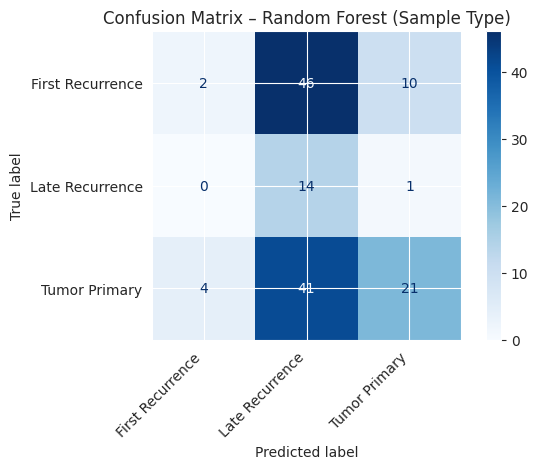

Logistic Regression Ergebnisse
Accuracy: 0.288

Confusion Matrix:
 [[ 9 43  6]
 [ 1 13  1]
 [ 8 40 18]]

Classification Report:
                   precision    recall  f1-score   support

First Recurrence       0.50      0.16      0.24        58
 Late Recurrence       0.14      0.87      0.23        15
   Tumor Primary       0.72      0.27      0.40        66

        accuracy                           0.29       139
       macro avg       0.45      0.43      0.29       139
    weighted avg       0.57      0.29      0.31       139



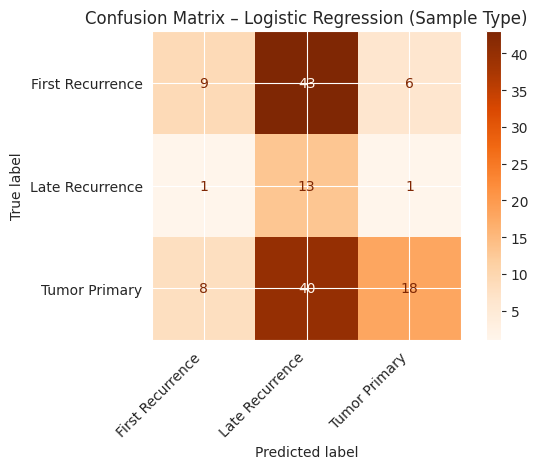

In [15]:
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from kneed import KneeLocator

clinical_data = pd.read_csv("hcai_data-main/combined_data.tsv.txt", sep="\t")

#print("Part 1:")
#print(clinical_data.shape)
#print(clinical_data.columns[:10])  #ersten 10 Spalten


##### auf sample type klassifizieren
print("Sample type: \n")
#print(clinical_data["Sample Type"])
clinical_data = clinical_data.dropna(subset=["Sample Type"]) #leere werte dropen
#survival columns dropen
clinical_data= clinical_data.drop("Overall Survival", axis='columns')
clinical_data= clinical_data.drop("Overall Survival (months)", axis='columns')
#print(clinical_data)
#labels: First Metastasis, Tumor Primary, First Recurrence, Second Recurrence, Third Recurrence, Fourth recurrence
cols = [
    "Sample Type",
    "Cancer Type Detailed"
]
df = clinical_data[cols].copy()

def reduce_sample_type(sample_type):
    if sample_type == "Tumor Primary":
        return "Tumor Primary"
    elif sample_type == "First Recurrence":
        return "First Recurrence"
    else :
        return "Late Recurrence" #First Metastasis, Second Recurrence, Third Recurrence, Fourth recurrence

df["Reduced Sample Type"] = df["Sample Type"].apply(reduce_sample_type)

# extract data from overal survival
'''def extract_survival_class(val):
    try:
        return int(str(val).split(":")[0])  # nimmt 0 oder 1
    except:
        return np.nan

clinical_data["Survival_Class"] = clinical_data["Overall Survival"].apply(extract_survival_class)
'''
# 

# handle nan values
#df["Age"] = df["Age"].fillna(df["Age"].median())
#df["Radiation Dose"] = df["Radiation Dose"].fillna(0)


df_encoded = pd.get_dummies(df.drop(columns=["Sample Type"]),  # drop old column
    columns=["Cancer Type Detailed"],
    drop_first=True
)

#label encoder verwenden, damit z.B. 0 = First Recurrence
encoder = LabelEncoder()
y = encoder.fit_transform(df_encoded["Reduced Sample Type"])
print("Zuordnung:\n")
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

X = df_encoded.drop(columns=["Reduced Sample Type"])#features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train - random forest
model = RandomForestClassifier(class_weight="balanced",random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Random Forest ---
print("Random Forest Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
#print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


#ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=encoder.classes_, cmap='Blues')
labels = unique_labels(y_test, y_pred)
class_names = encoder.inverse_transform(labels)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Logistic Regression ---
log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
#print("\nClassification Report:\n", classification_report(y_test, y_pred_log, target_names=encoder.classes_))


#ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, display_labels=encoder.classes_, cmap='Oranges')
labels_log = unique_labels(y_test, y_pred_log)
class_names_log = encoder.inverse_transform(labels_log)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_log,
                            labels=labels_log,
                            target_names=class_names_log))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=class_names_log,
    cmap='Oranges'
)
plt.title("Confusion Matrix – Logistic Regression (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

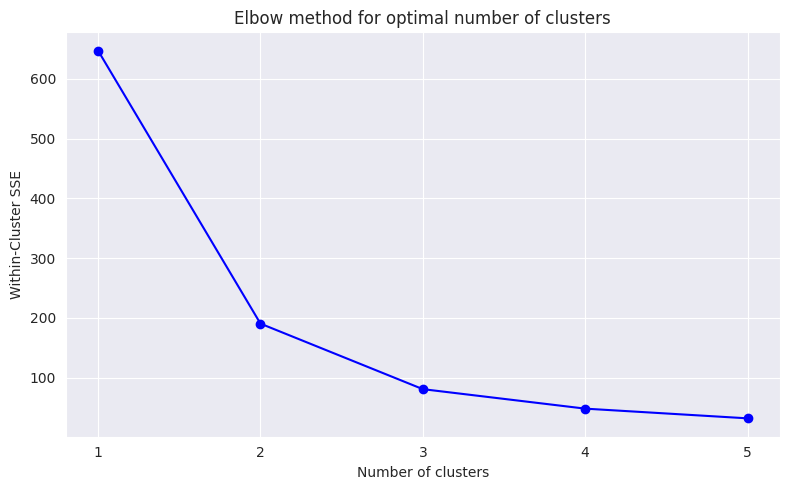

Optimal number of clusters according to elbow method: 2

Cluster vs. Reduced Sample Type

Rounded crosstab value Reduced Sample Type  Tumor Primary  First Recurrence  Late Recurrence
Cluster                                                              
0                             0.40              0.48             0.12
1                             0.54              0.41             0.04


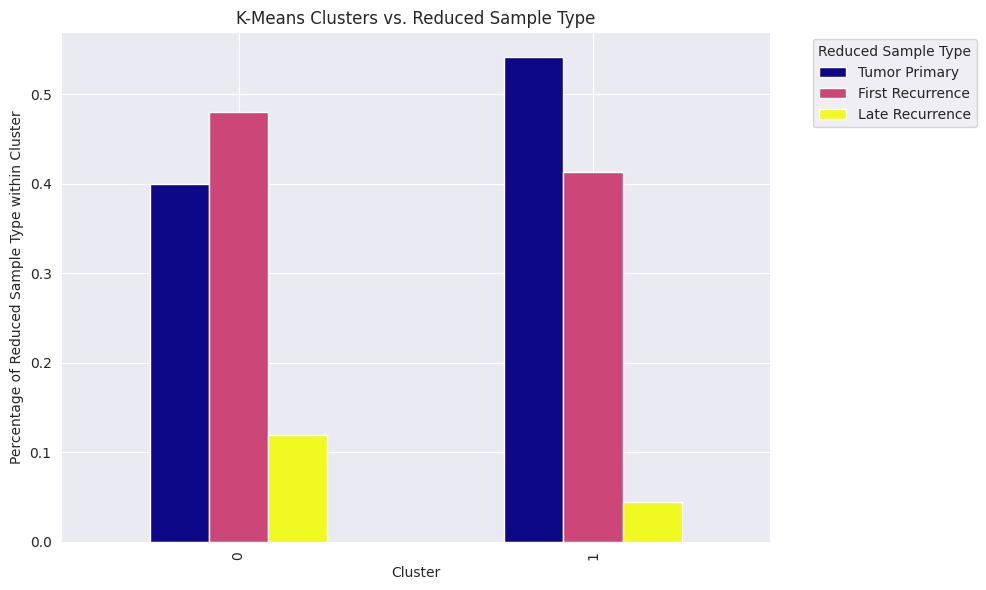

Number of samples per cluster

Reduced Sample Type  Tumor Primary  First Recurrence  Late Recurrence
Cluster                                                              
0                              187               225               56
1                              122                93               10


In [20]:
#------Elbow method to find optimal number of clusters----#
sse = [] #ssum of sqaured errors
K = range(1, 6) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster SSE')
plt.title('Elbow method for optimal number of clusters')
plt.xticks(K)
plt.grid(True)
plt.tight_layout()
plt.show()

#kneelocator to print out optimal number of clusters
knee = KneeLocator(K, sse, curve='convex', direction='decreasing')
print(f"Optimal number of clusters according to elbow method: {knee.knee}\n")

#---------K-Means---------#
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

X["Cluster"] = clusters

# labels nicht encoded
df_analysis = df_encoded.copy()
df_analysis["Cluster"] = clusters
df_analysis["Sample Type"] = df["Reduced Sample Type"].values 

#-----comparison Cluster vs. Sample Type------#
#crosstab computes a simple cross tabulation of two (or more) factors
column_order = ["Tumor Primary", "First Recurrence", "Late Recurrence"]
crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Reduced Sample Type"], normalize='index')[column_order]
print("Cluster vs. Reduced Sample Type\n")
print("Rounded crosstab value", crosstab.round(2))
crosstab.plot(kind='bar', stacked=False, colormap='plasma', figsize=(10,6))
plt.title("K-Means Clusters vs. Reduced Sample Type")
plt.ylabel("Percentage of Reduced Sample Type within Cluster")
plt.xlabel("Cluster")
plt.legend(title="Reduced Sample Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#number of each Sample Types per cluster 
raw_crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Reduced Sample Type"])[column_order]
print("Number of samples per cluster\n")
print(raw_crosstab)
